## 1. Initialize & Test Model

### 1.0. Imports

In [1]:
# Update sys path for imports to work
import sys
# print(f"Before: {"\n".join(sys.path)}")  ## Optional print to check
sys.path.append("../../../LLMFromScratch")
# print(f"After: {"\n".join(sys.path)}")  ## Optional print to check

In [2]:
import torch

from M0_data.helpers import GPT2Tokenizer, create_data_loader
from M1_simple_gpt_model.generate import generate_text
from M1_simple_gpt_model.trial_gpt_model import TrialGPTModel

### 1.1. Initialize Model

In [3]:
GPT_CONFIG_124M = {
    "context_length": 256, # Context Length supported by the model; Using reduced size to reduce compute resources; Actual value: 1024
    "drop_rate" : 0.1,  # Tring with smaller prob number, Can be kept zero.
    "emb_dim": 768,  # Dimension of Embedding to be created
    "n_heads": 12,  # Number of heads in Multi-Head Attention
    "n_layers": 12,  # Number of times Transformer block is repeated
    "qvbias": False,  # Skipping bias terms to make the transformers training faster
    "vocab_size": 50257,  # Size of gpt2 tokenizer used
}

In [4]:
torch.manual_seed(123)  # For consistent reproducibility
model = TrialGPTModel(GPT_CONFIG_124M)

In [5]:
model.eval() # Switch to Evaluation mode - NOT Train

TrialGPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm_1): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (linear_query): Linear(in_features=768, out_features=768, bias=False)
        (linear_key): Linear(in_features=768, out_features=768, bias=False)
        (linear_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj_linear): Linear(in_features=768, out_features=768, bias=True)
      )
      (drop_out): Dropout(p=0.1, inplace=False)
      (norm_2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )

### 1.2. Sample Test Inputs

In [6]:
# Sample Inputs - of Different lengths
in_strings = ["Every effort moves you towards your goal",
              "Every day holds a",
              "This statement is going to have longest token length "]

### 1.3. Tokenize

In [7]:
tokenizer = GPT2Tokenizer()
tokenized_in_strings = tokenizer.tokenize_batch(in_strings)
tokenized_in_strings.shape  # batch_size * in_seq_len

torch.Size([3, 10])

### 1.4. Generate Output with model

In [8]:
output_tokens = generate_text(model, tokenized_in_strings, 1, GPT_CONFIG_124M["context_length"])

In [9]:
output_tokens.shape  # batch_size * min(in_seq_len, context_length)+1

torch.Size([3, 11])

### 1.5. Detokenize

In [10]:
output = tokenizer.detokenize_batch(output_tokens)
output

['Every effort moves you towards your goal inv',
 'Every day holds a respec',
 'This statement is going to have longest token length �']

## 2. Load Trial data & Tokenize

In [11]:
with open("../../M0_data/ponniyinselvan.txt", "r", encoding="utf-8") as read_file:
    raw_text = read_file.read()

# Print length
print(len(raw_text))

# Print first 100 characters
print(raw_text[:99])

# Print last 100 characters
print(raw_text[-99:])

20161
The story revolves around Vandiyathevan, a charming, brave and courageous young man who sets out ac
nd meet Manimegalai. Vandiyathevan goes to meet Manimegalai, who loved him, and dies in his hands.



In [12]:
tokenized_raw_text = tokenizer.tokenize_batch(raw_text)
tokenized_raw_text.shape

torch.Size([1, 5330])

## 3. Train and Validation Split

### 3.1. Initialize config values

In [13]:
batch_size = 2  # Small as short training set; Actual Size in Llama2 7B: 1024
train_ratio = 0.90  # 90% Train set
torch.manual_seed(123)  # For consistent reproducibility

### 3.2 Actual Split to Train and Validation Set

In [14]:
split_idx = int(len(raw_text) * train_ratio)
print(split_idx)

18144


In [15]:
# Train Set
train_set = raw_text[:split_idx]
train_loader = create_data_loader(train_set,
                                  max_length=GPT_CONFIG_124M["context_length"],
                                  stride=GPT_CONFIG_124M["context_length"],
                                  batch_size=batch_size,
                                  shuffle=True,  # For training shuffling is ok
                                  drop_last=True,
                                  num_workers=0)

In [16]:
# Validation Set
validation_set = raw_text[split_idx:]
validation_loader = create_data_loader(validation_set,
                                       max_length=GPT_CONFIG_124M["context_length"],
                                       stride=GPT_CONFIG_124M["context_length"],
                                       batch_size=batch_size,
                                       shuffle=False,  # For validation shuffling is turned off
                                       drop_last=False,  # Need to infer on last short batch as well
                                       num_workers=0)

In [17]:
# Save to forward to next steps
torch.save(train_loader, "intermediates/train_loader.pt")
torch.save(validation_loader, "intermediates/validation_loader.pt")

### 3.3 Test Data loaded

In [18]:
# Train set
train_tokens = 0
for in_data, out_data in train_loader:
    print(in_data.shape, out_data.shape)
    train_tokens += in_data.numel()

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [19]:
# Validation set
validation_tokens = 0
for in_data, out_data in validation_loader:
    print(in_data.shape, out_data.shape)
    validation_tokens += in_data.numel()

torch.Size([2, 256]) torch.Size([2, 256])


In [20]:
# Token count verification
print(f"Train Tokens: {train_tokens}")
print(f"Validation Tokens: {validation_tokens}")
print(f"Total Tokens: {train_tokens + validation_tokens}")

Train Tokens: 4608
Validation Tokens: 512
Total Tokens: 5120


## 4. Initial Loss before Training

### Cross Entropy Formula
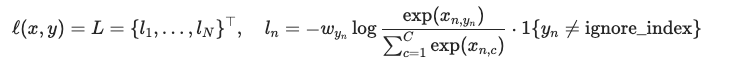

Notes: 
1. The input can be logits as it is normalised by dividing by sum across classes in formula above
2. When Batch is provided i.e. Tensor [Batch, Classes], by default output loss is mean across batch

In [21]:
# Helper Functions

def calc_loss_batch(input_batch, target_batch, device, model):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    logits, target_batch = logits.flatten(0, 1), target_batch.flatten()  # flatten(start, end) Flattens dimensions from start to end idx specified
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_multi_batch(data_loader, device, model):
    num_batches = len(data_loader)

    if num_batches == 0:
        return float("nan")

    total_loss = 0.
    for input_batch, target_batch in data_loader:
        total_loss += calc_loss_batch(input_batch, target_batch, device, model)
    return total_loss / num_batches

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

TrialGPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm_1): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (linear_query): Linear(in_features=768, out_features=768, bias=False)
        (linear_key): Linear(in_features=768, out_features=768, bias=False)
        (linear_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj_linear): Linear(in_features=768, out_features=768, bias=True)
      )
      (drop_out): Dropout(p=0.1, inplace=False)
      (norm_2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )

In [23]:
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

In [24]:
with torch.no_grad():  # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_multi_batch(train_loader, device, model)
    val_loss = calc_loss_multi_batch(validation_loader, device, model)

In [25]:
print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Train Loss: 10.96826457977295
Validation Loss: 10.963376998901367
